![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/streamlit_notebooks/ocr/DICOM_TO_TEXT.ipynb)

# DICOM to Text
Recognize text and extract metada from DICOM format documents.

To run this yourself, you will need to upload your **Spark OCR** license keys to the notebook. Otherwise, you can look at the example outputs at the bottom of the notebook. To upload license keys, open the file explorer on the left side of the screen and upload `workshop_license_keys.json` to the folder that opens.

For more in-depth tutorials: https://github.com/JohnSnowLabs/spark-ocr-workshop/tree/master/jupyter

## 1. Colab Setup

Install correct version of Pillow and Restart runtime

In [ ]:
# Install correct Pillow version
import PIL
if PIL.__version__  != '6.2.1':
  print ('Installing correct version of Pillow. Kernel will restart automatically')
  !pip install --upgrade pillow==6.2.1
  # hard restart runtime
  import os
  os.kill(os.getpid(), 9)
else:
  print ('Correct Pillow detected')

Correct Pillow detected


Read licence key

In [ ]:
import os
import json

with open('workshop_license_keys.json') as f:
    license_keys = json.load(f)

print (license_keys.keys())

secret = license_keys['JSL_OCR_SECRET']
os.environ['SPARK_OCR_LICENSE'] = license_keys['SPARK_OCR_LICENSE']
os.environ['JSL_OCR_LICENSE'] = license_keys['SPARK_OCR_LICENSE']
version = secret.split("-")[0]
print ('Spark OCR Version:', version)

dict_keys(['JSL_OCR_SECRET', 'SPARK_OCR_LICENSE'])
Spark OCR Version: 1.5.0


Install Dependencies

In [ ]:
# Install Java
!apt-get update
!apt-get install -y openjdk-8-jdk
!java -version

# Install pyspark, SparkOCR, and SparkNLP
!pip install --ignore-installed -q pyspark==2.4.4
# Insall Spark Ocr from pypi using secret
!python -m pip install --upgrade spark-ocr==$version  --extra-index-url https://pypi.johnsnowlabs.com/$secret
# or install from local path
# %pip install --user ../../python/dist/spark-ocr-[version].tar.gz
!pip install --ignore-installed -q spark-nlp==2.5.2

Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import os

#Pyspark Imports
from pyspark.sql import SparkSession
from pyspark.ml import PipelineModel
from pyspark.sql import functions as F

# Necessary imports from Spark OCR library
from sparkocr import start
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import display_image, to_pil_image
from sparkocr.metrics import score
import pkg_resources

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]


Start Spark Session

In [ ]:
spark = start(secret=secret)
spark

## 2. Download and read DICOM image

download image

In [ ]:
!wget https://github.com/JohnSnowLabs/spark-ocr-workshop/raw/master/jupyter/data/dicom/deidentify-medical-1.dcm -O image.dcm

--2020-08-10 09:46:06--  https://github.com/JohnSnowLabs/spark-ocr-workshop/raw/master/jupyter/data/dicom/deidentify-medical-1.dcm
Resolving github.com (github.com)... 140.82.118.3
Connecting to github.com (github.com)|140.82.118.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/JohnSnowLabs/spark-ocr-workshop/master/jupyter/data/dicom/deidentify-medical-1.dcm [following]
--2020-08-10 09:46:07--  https://raw.githubusercontent.com/JohnSnowLabs/spark-ocr-workshop/master/jupyter/data/dicom/deidentify-medical-1.dcm
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 640574 (626K) [application/octet-stream]
Saving to: ‘image.dcm’

image.dcm           100%[===================>] 625.56K  --.-KB/s    in 0.03s  

In [ ]:
image_df = spark.read.format("binaryFile").load('image.dcm').cache()
image_df.show()

+--------------------+-------------------+------+--------------------+
|                path|   modificationTime|length|             content|
+--------------------+-------------------+------+--------------------+
|file:/content/ima...|2020-08-10 09:46:07|640574|[00 00 00 00 00 0...|
+--------------------+-------------------+------+--------------------+



## 3. Construct the OCR pipeline

In [ ]:
# Extract images from Dicom format
dicom_to_image = DicomToImage() \
    .setInputCol("content") \
    .setOutputCol("image_raw") \
    .setMetadataCol("metadata") \
    .setDeIdentifyMetadata(True)

# Extract text from image
ocr = ImageToText() \
    .setInputCol("image_raw") \
    .setOutputCol("text") \
    .setIgnoreResolution(False) \
    .setOcrParams(["preserve_interword_spaces=0"])


# OCR pipeline
pipeline = PipelineModel(stages=[
    dicom_to_image,
    ocr
])


## 4. Run OCR pipeline

In [ ]:
result = pipeline.transform(image_df).cache()

## 5. Visualize Results

Display result dataframe

In [ ]:
result.select("text", "confidence").show()

+--------------------+-----------------+
|                text|       confidence|
+--------------------+-----------------+
|OA yer

2018 Oct ...|84.46388498942058|
+--------------------+-----------------+



Display dicom image, extracted text and metadata, and save dicom image as jpg

Image:
        origin: file:/content/image.dcm 
        width: 800
        height: 800
        mode: 10


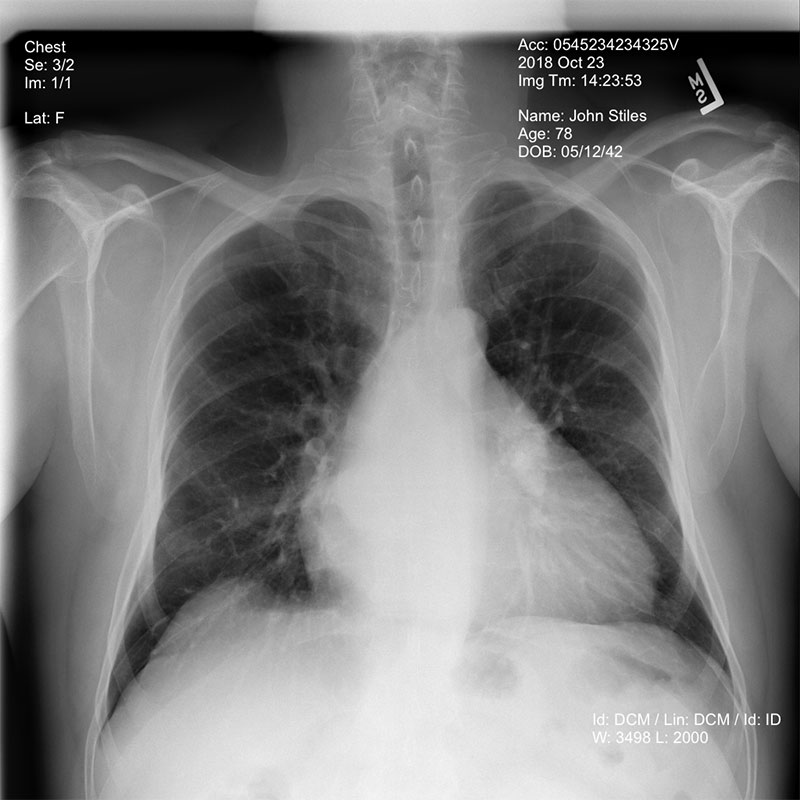

OA yer

2018 Oct 23

Img Tm: 14:23:53
%

Name: John Stiles

 


{
    "00020001": {
        "vr": "OB",
        "InlineBinary": "AAE="
    },
    "00020002": {
        "vr": "UI",
        "Value": [
            "2.25.170228217341328822848560557903560820700"
        ]
    },
    "00020003": {
        "vr": "UI",
        "Value": [
            "2.25.214240140729127103672606000638950934948"
        ]
    },
    "00020010": {
        "vr": "UI",
        "Value": [
            "1.2.840.10008.1.2.1"
        ]
    },
    "00020012": {
        "vr": "UI",
        "Value": [
            "1.3.6.1.4.1.30071.8"
        ]
    },
    "00020013": {
        "vr": "SH",
        "Value": [
            "fo-dicom 4.0.0"
        ]
    },
    "00080020": {
        "vr": "DA"
    },
    "00080050": {
        "vr": "SH"
    },
    "00080080": {
        "vr": "LO",
        "Value": [
            "REMOVED"
        ]
    },
    "00100010": {
        "vr": "PN"
    },
    "00100020": {
        "vr": "LO"
    },
 

In [ ]:
for r in result.distinct().collect():
  display_image(r.image_raw)
  print (r.text)
  print (r.metadata)
  img = to_pil_image(r.image_raw, r.image_raw.mode)
  img.save('image.jpg')